# Automatic Differentiation

Parts of this is inspired by [this tutorial](https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/2.%20Automatic%20Differentiation.ipynb)

In many applications it is crucial to compute derivatives such as machine learning, optimization problems, and so on. Often the most basis idea is to approximate the gradient of a function by computing a finite difference approximation
$$
\frac{f(x_1+h,x_2,\ldots,x_n)-f(x_1,x_2,\ldots,x_n)}{h}
$$
or numerically a little better using a centered difference
$$
\frac{f(x_1+h,x_2,\ldots,x_n)-f(x_1-h,x_2,\ldots,x_n)}{2h}
$$



In [1]:
import numpy as np
import matplotlib.pylab as plt

def diff_f(x,h):
    fvec = np.exp(x)
    y = np.abs((np.exp(x+h)-np.exp(x-h))/(2*h)-fvec)/np.abs(fvec)
    return y

def diff2_f(x,h):
    fvec = np.exp(x)
    y = np.abs((np.exp(x+h)-np.exp(x))/(h)-fvec)/np.abs(fvec)
    return y

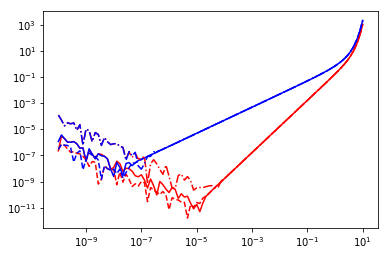

In [2]:
x1 = np.logspace(-10, 1, 100, endpoint=True)# range of h parameter
y = diff_f(5,x1)
y2 = diff2_f(5,x1)
plt.loglog(x1, y,color='red')
plt.loglog(x1, y2,color='blue')
y = diff_f(2,x1)
y2 = diff2_f(2,x1)
plt.loglog(x1, y,color='red',linestyle='--')
plt.loglog(x1, y2,color='blue',linestyle='--')
y = diff_f(150,x1)
y2 = diff2_f(150,x1)
plt.loglog(x1, y,color='red',linestyle='-.')
plt.loglog(x1, y2,color='blue',linestyle='-.')
plt.show()

This method can be quite slow and is prone to rounding errors. The following Figure illustrates the main idea behind back propagation which is based on automatic differentiation.
![](https://miro.medium.com/max/771/1*DcLWqOojI1b9jzQaLibUkQ.png)

> The **backpropagation** algorithm was originally introduced in the 1970s, but its importance wasn't fully appreciated until a famous 1986 paper by David Rumelhart, Geoffrey Hinton, and Ronald Williams.

> **Backpropagation** is the key algorithm that makes training deep models computationally tractable. For modern neural networks, it can make training with gradient descent as much as ten million times faster, relative to a naive implementation. That’s the difference between a model taking a week to train and taking 200,000 years. (Christopher Olah, 2016)

We have seen that in order to optimize our models we need to compute the derivative of the loss function with respect to all model paramaters. 

The computation of derivatives in computer models is addressed by four main methods: 

+ Manually working out derivatives and coding the result (as in the original paper describing backpropagation); 

![alt text](https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/back.png?raw=1)

+ Numerical differentiation (using finite difference approximations); 
+ Symbolic differentiation (using expression manipulation in software, such as `Sympy`); 
+ and Automatic differentiation (AD).

**Automatic differentiation** (AD) works by systematically applying the **chain rule** of differential calculus at the elementary operator level.

Let $ y = f(g(x)) $ be our target function. In its basic form, the chain rule states:

$$ \frac{\partial y}{\partial x} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x} $$

or, if there are more than one variable $g_i$ in-between $y$ and $x$ (f.e. if $f$ is a two dimensional function such as $f(g_1(x), g_2(x))$), then:

$$ \frac{\partial f}{\partial x} = \sum_i \frac{\partial f}{\partial g_i} \frac{\partial g_i}{\partial x} $$

> See http://tutorial.math.lamar.edu/Classes/CalcIII/ChainRule.aspx

Now, let's see how AD allows the accurate evaluation of derivatives at machine precision, with only a small constant factor of overhead.

In its most basic description, AD relies on the fact that all numerical computations
are ultimately compositions of a finite set of elementary operations for which derivatives are known.

For example, let's consider the computation of the derivative of the sigmoid

$$
    f(x) = \frac{1}{1 + e^{- ({w}^T \cdot  x + b)}} 
$$


First, let's write how to evaluate $f(x)$ via a sequence of primitive operations (here for scalar $w$ and $x$):


```python
x = ?
f1 = w * x
f2 = f1 + b
f3 = -f2
f4 = 2.718281828459 ** f3
f5 = 1.0 + f4
f = 1.0/f5
```

The question mark indicates that $x$ is a value that must be provided. 

This *program* can compute the value of $x$ and also **populate program variables**, which means to give the defined variables a value. 

We can evaluate $\frac{\partial f}{\partial x}$ at some $x$ by using the chain rule. This is called **forward-mode differentiation**. 

In principle we follow
$$
\frac{\partial y}{\partial x}=\frac{\partial y}{\partial w_{n-1}}\frac{\partial w_{n-1}}{\partial x}=\frac{\partial y}{\partial w_{n-1}}\left(\frac{\partial w_{n-1}}{\partial w_{n-2}}\frac{\partial w_{n-2}}{\partial x}\right)=\ldots
$$

In our case:

In [3]:
def f(x,w,b):
    f1 = w * x
    f2 = f1 + b
    f3 = -f2
    f4 = 2.718281828459 ** f3
    f5 = 1.0 + f4
    return 1.0/f5

In [4]:
def dfdx_forward(x, w, b):
    f1 = w * x
    p1 = w                          # p1 = df1/dx
    f2 = f1 + b
    p2 = 1.0*p1                     # p2 = df2/df1*p1 
    f3 = -f2
    p3 = -1.0*p2                    # p3 = df3/df2*p2
    f4 = 2.718281828459 ** f3
    p4 = 2.718281828459 ** f3 *p3    # p4 = df4/df3*p3
    f5 = 1.0 + f4
    p5 = 1.0*p4                     # p5 = df5/df4*p4
    f6 = 1.0/f5
    dfx = -1.0 / f5 ** 2.0*p5        # df/dx = df6/df5*p5
    return f6, dfx

In [5]:
h = 0.000001;
der = (f(3+h, 2, 1) - f(3, 2, 1))/h

print("Value of the function at (3, 2, 1): ",f(3, 2, 1))
print("df/dx Derivative (fin diff) at (3, 2, 1): ",der)
print("df/dx Derivative (aut diff) at (3, 2, 1): ",dfdx_forward(3, 2, 1)[1])
print("The difference between both is given as:",dfdx_forward(3, 2, 1)[1]-der)

Value of the function at (3, 2, 1):  0.9990889488055992
df/dx Derivative (fin diff) at (3, 2, 1):  0.0018204406870836465
df/dx Derivative (aut diff) at (3, 2, 1):  0.0018204423602438654
The difference between both is given as: 1.6731602188804762e-09


We consider the function 
$$
g(x_1,x_2)=\sin(x_1)+x_1x_2
$$

In [6]:
import math

def g(x1,x2):
    f1 = x1
    f2 = x2
    f3 = f1*f2
    f4 = math.sin(f1)
    f5 = f4+f3
    
    return f5

In [7]:
def dgdx1_forward(x1,x2):
    f1 = x1
    p1 = 1  # p1=df1/dx1
    f2 = x2
    p2 = 0  # p2=df2/dx1
    f3 = f1*f2
    p3 = p1*f2+p2*f1 # p3 = f1'f2+f1f2'
    f4 = math.sin(f1)
    p4 = math.cos(f1)*p1 # d
    f5 = f4+f3
    p5 = p4+p3;
    return p5
    

In [8]:
def dgdx1_forward2(x1,x2):
    f1 = x1
    p1 = 0  # p1=df1/dx1
    f2 = x2
    p2 = 1  # p2=df2/dx1
    f3 = f1*f2
    p3 = p1*f2+p2*f1 # p3 = f1'f2+f1f2'
    f4 = math.sin(f1)
    p4 = math.cos(f1)*p1 # d
    f5 = f4+f3
    p5 = p4+p3;
    return p5

In [9]:
h = 0.0000001;
der = (g(3+h, 1) - g(3,1))/h
print("Value of the function at (3, 2, 1): ",g(3, 1))
print("dg/dx1 Derivative (fin diff) at (3, 2, 1): ",der)
print("dg/dx1 Derivative (aut diff) at (3, 2, 1): ",dgdx1_forward(3, 1))
print("The difference between both is given as:",dgdx1_forward(3, 1)-der) 

Value of the function at (3, 2, 1):  3.1411200080598674
dg/dx1 Derivative (fin diff) at (3, 2, 1):  0.010007497053265979
dg/dx1 Derivative (aut diff) at (3, 2, 1):  0.010007503399554585
The difference between both is given as: 6.346288605740824e-09


In [10]:
h = 0.0000001;
der = (g(3, 1+h) - g(3,1))/h
print("Value of the function at (3, 2, 1): ",g(3, 1))
print("dg/dx1 Derivative (fin diff) at (3, 2, 1): ",der)
print("dg/dx1 Derivative (aut diff) at (3, 2, 1): ",dgdx1_forward2(3, 1))
print("The difference between both is given as:",dgdx1_forward2(3, 1)-der) 

Value of the function at (3, 2, 1):  3.1411200080598674
dg/dx1 Derivative (fin diff) at (3, 2, 1):  2.9999999995311555
dg/dx1 Derivative (aut diff) at (3, 2, 1):  3.0
The difference between both is given as: 4.688445187639445e-10


It is interesting to note that this *program* can be automatically derived  if we have access to **subroutines implementing the derivatives of primitive functions** (such as $\exp{(x)}$ or $1/x$) and all intermediate variables are computed in the right order. 

It is also interesting to note that AD allows the accurate evaluation of derivatives at **machine precision**, with only a small constant factor of overhead.



The above can be viewed as differentiation of each equation with respect to some yet-to-be-given variable $x$ via the chain schematically given as
$$
\frac{\partial y}{\partial x}=\frac{\partial y}{\partial w_{n-1}}\frac{\partial w_{n-1}}{\partial x}=\frac{\partial y}{\partial w_{n-1}}\left(\frac{\partial w_{n-1}}{\partial w_{n-2}}\frac{\partial w_{n-2}}{\partial x}\right)=\ldots
$$
where we can substitute $x=x_1$ or $x=x_2$ to obtain the desired derivative. This forward differentiation is efficient for functions $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $n \ll m$ (only $O(n)$ sweeps are necessary) as we need to call the function for $n$ different values of $x$. What if we want to avoid this?

Alternatively, we can consider a backward version of the differentiation by proceeding as follows
\begin{align}
\frac{\partial y}{\partial x}=\frac{\partial y}{\partial w_1}\frac{\partial w_1}{\partial x}=\left(\frac{\partial y}{\partial w_2}\frac{\partial w_2}{\partial w_1}\right)\frac{\partial w_1}{\partial x}=\ldots
\end{align}
using the function

```python
    w1 = x1
    w2 = x2
    w3 = w1*w2
    w4 = math.sin(w1)
    w5 = w4+w3
```

Let’s take a second look at the chain rule we used to derive forward-mode AD for a generic variable $t$

$$
\frac{\partial w}{\partial t}
=
\sum_i
(
\frac{\partial y}{\partial w_i}
\frac{\partial w_i}{\partial t}
)
=
\frac{\partial y}{\partial w_1}
\frac{\partial w_1}{\partial t}
+
\frac{\partial y}{\partial w_2}
\frac{\partial w_2}{\partial t}
+\ldots
$$

To calculate the gradient using forward-mode AD, we had to perform two substitutions: one with $t=x_1$
and another with $t=x_2$.

This means we have to **run the code twice.**

However, the chain rule is symmetric: it doesn’t care what’s in the “numerator” or the “denominator”. So let’s rewrite the chain rule but turn the derivatives upside down:

$$
\frac{\partial z}{\partial w_j}
=
\sum_i
(
\frac{\partial w_i}{\partial w_j}
\frac{\partial z}{\partial w_i}
)
=
\frac{\partial w_1}{\partial w_j}
\frac{\partial z}{\partial w_1}
+
\frac{\partial w_2}{\partial w_j}
\frac{\partial z}{\partial w_2}
+\ldots
$$

In this case we obtain the derivative with respect to a variable $w_j$ for some $j$ where $z$ is the output variable
$$
z=h(x_1,x_2)=x_1x_2+\sin(x_1)
$$
and here we assume this is only one.

Reverse mode automatic differentiation proceeds by computing for $z=w_5$ that
$$
\frac{\partial z}{\partial z}=\frac{\partial z}{\partial w_5}=1.
$$
Now we know that $w_5=w_4+w_3$ and hence we get
$$
\frac{\partial w_5}{\partial w_4}=1,\quad\frac{\partial w_5}{\partial w_3}=1.
$$
Now using the chain rule we get
\begin{align}
\frac{\partial z}{\partial w_3}&=\frac{\partial z}{\partial w_5}\frac{\partial w_5}{\partial w_3}=1\\
\frac{\partial z}{\partial w_4}&=\frac{\partial z}{\partial w_5}\frac{\partial w_5}{\partial w_4}=1.\\
\end{align}

Now, we remember that $w_3=w_2w_1$ and get $\frac{\partial w_3}{\partial w_2}=w_1$ and  $\frac{\partial w_3}{\partial w_1}=w_2$. This can be combined to obtain the following derivative
$$
\frac{\partial z}{\partial w_2}=\frac{\partial z}{\partial w_3}\frac{\partial w_3}{\partial w_2}=1\cdot w_1=x_1.
$$
Also, $w_1$ contributes to $z$ and we get
\begin{align}
\frac{\partial z}{\partial w_1}&=\frac{\partial z}{\partial w_3}\frac{\partial w_3}{\partial w_1}+\frac{\partial z}{\partial w_4}\frac{\partial w_4}{\partial w_1}\\
&=w_2+\mathrm{cos}(w_1)\\
&=x_2+\mathrm{cos}(x_1)\\
\end{align}

This is called *reverse-mode differentiation* or *backwards propagation*. Reverse pass starts at the end (i.e. $\frac{\partial z}{\partial z} = 1$) and propagates backward to all dependencies.

In [11]:
def dgdx_backward(x1, x2):
    import numpy as np
    w1 = x1
    w2 = x2
    w3 = w1*w2
    w4 = math.sin(w1)
    w5 = w4+w3
    z = w5
    
    dz = 1             # pf = df/df
    d5d4 = dz*1.0         # p5 = pf * df/df5 
    d5d3 = dz*1.0                      # p4 = p5 * df5/df4
    d3d2 = w1       # p3 = p4 * df4/df3
    d3d1 = w2
    d4d1 = math.cos(w1)    # p2 = p3 * df3/df2
    dzd1 = d5d3*d3d1+d5d4*d4d1                      # p1 = p2 * df2/df1
    dzd2 = d5d3*d3d2                      # df/dx = p1 * df1/dx 
    return dzd1, dzd2

In [12]:
h = 0.0000001;
der1 = (g(1+h, 2) - g(1,2))/h
der2 = (g(1, 2+h) - g(1,2))/h

print("Finite difference approximation:",der1,der2)
print("dg/dx Derivative (aut diff) at (3, 2, 1): ",
      dgdx_backward(1, 2))

Finite difference approximation: 2.540302261877514 0.999999993922529
dg/dx Derivative (aut diff) at (3, 2, 1):  (2.5403023058681398, 1.0)


In practice, reverse-mode differentiation is a two-stage process. In the first stage the original function code is run forward, populating the $w_i$ variables. In the second stage, derivatives are calculated by propagating in reverse, from the outputs to the inputs.

The most important property of reverse-mode differentiation is that it is **cheaper than forward-mode differentiation for functions with a high number of input variables**. For a function of the form $f : \mathbb{R}^n \rightarrow \mathbb{R}$, only one application of the reverse mode is sufficient to compute the full gradient of the function $\nabla f = \big( \frac{\partial y}{\partial x_1}, \dots ,\frac{\partial y}{\partial x_n} \big)$. This is the case of deep learning, where the number of input variables is very high. 

> As we have seen, AD relies on the fact that all numerical computations
are ultimately compositions of a finite set of elementary operations for which derivatives are known. 


## Autograd

Autograd is a Python module (with only one function) that implements automatic differentiation.

Autograd can automatically differentiate Python and Numpy code:

+ It can handle most of Python’s features, including loops, if statements, recursion and closures.
+ Autograd allows you to compute gradients of many types of data structures (Any nested combination of lists, tuples, arrays, or dicts).
+ It can also compute higher-order derivatives.
+ Uses reverse-mode differentiation (backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued or vector-valued arguments.
+ You can easily implement your custom gradients (good for speed, numerical stability, non-compliant code, etc).

In [13]:
import autograd.numpy as np
from autograd import grad

x1 = np.array([2, 5], dtype=float)
x2 = np.array([5, 2], dtype=float)

def test(x):
    if x[0]>3:
        return np.log(x[0]) + x[0]*x[1] - np.sin(x[1])
    else:
        return np.log(x[0]) + x[0]*x[1] + np.sin(x[1])
      
grad_test = grad(test)


print("({:.2f},{:.2f})".format(grad_test(x1)[0],grad_test(x1)[1]))
print("({:.2f},{:.2f})".format(grad_test(x2)[0],grad_test(x2)[1]))

ModuleNotFoundError: No module named 'autograd'

The ``grad`` function:

````
grad(fun, argnum=0, *nary_op_args, **nary_op_kwargs)

Returns a function which computes the gradient of `fun` with respect to positional argument number `argnum`. The returned function takes the same arguments as `fun`, but returns the gradient instead. The function `fun` should be scalar-valued. The gradient has the same type as the argument.
```

Then, a simple (there is no bias term) logistic regression model for $n$-dimensional data like this

$$  f(x) = \frac{1}{1 + \exp^{-(\mathbf{w}^T \mathbf{x})}} $$

can be implemented in this way:

In [14]:
import autograd.numpy as np
from autograd import grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    loss = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(loss))

def optimize(inputs, targets, training_loss):
    # Optimize weights using gradient descent.
    gradient_loss = grad(training_loss)
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in range(100):
        weights -= gradient_loss(weights, inputs, targets) * 0.01
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

ModuleNotFoundError: No module named 'autograd'

In [15]:
# Build a toy dataset with 3d data
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

weights = optimize(inputs, targets, training_loss)
print("Weights:", weights)

NameError: name 'optimize' is not defined